In [4]:
import numpy as np
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt

In [5]:
def inputdata(fnameR, nod, nfree):  #データパス, 要素節点数, 自由度
    f = open(fnameR, 'r')
    text = f.readline()  # コメント
    text = f.readline()  # 1行ずつ読み込む
    text = text.strip()  # 端の空白, 改行(\n)を削除
    text = text.split()  # ','　で別れた要素ごとの配列にする
    npoin = int(text[0])  # ノード数
    nele = int(text[1])  # 要素数
    npfix = int(text[2])  # 拘束点数
    nlod = int(text[3])  # 荷重点数
    delta_t = float(text[4])  # 微小時間
    n_t = int(text[5])  # 微小時間数
    # 配列宣言
    ae = np.zeros((11, nele), dtype=np.float64)  # 要素特性
    node = np.zeros((nod + 1, nele), dtype=np.int)  # 要素構成節点
    x = np.zeros((3, npoin), dtype=np.float64)  # 座標
    mpfix = np.zeros((n_t + 1, nfree, npoin), dtype=np.int)  # 拘束状態
    rdis = np.zeros((n_t + 1, nfree, npoin), dtype=np.float64)  # 既知変位
    fp = np.zeros((n_t + 1, nfree * npoin), dtype=np.float64)  # 外力
    # 要素特性: ae
    text = f.readline()  # コメント
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        ae[0, i] = float(text[0])  # E
        ae[1, i] = float(text[1])  # Po
        ae[2, i] = float(text[2])  # A
        ae[3, i] = float(text[3])  # Ix
        ae[4, i] = float(text[4])  # Iy
        ae[5, i] = float(text[5])  # Iz
        ae[6, i] = float(text[6])  # density
        ae[7, i] = float(text[7])  # gkx
        ae[8, i] = float(text[8])  # gky
        ae[9, i] = float(text[9])  # gkz

    text = f.readline()  # コメント
    # 要素構成節点: node
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        node[0, i] = int(text[0])  #node_1
        node[1, i] = int(text[1])  #node_2
        node[2, i] = int(text[2])  #要素番号

    text = f.readline()  # コメント
    # 座標: x
    for i in range(0, npoin):
        text = f.readline()
        text = text.strip()
        text = text.split()
        x[0, i] = float(text[0])  # x-座標
        x[1, i] = float(text[1])  # y-座標
        x[2, i] = float(text[2])  # z-座標
    
    # 要素質量
    for i in range(0, nele):
        node1_x = x[0, i]
        #         node1_y = x[1, i]
        #         node1_z = x[2, i]
        node2_x = x[0, i + 1]
        #         node2_y = x[1, i+1]
        #         node2_z = x[2, i+1]
        A = ae[2, i]
        density = ae[6, i]
        ae[10, i] = abs(node1_x - node2_x) * A * density
        
#     for j in range(0, n_t+1):

    text = f.readline()  # コメント
    # 境界条件（拘束状態） (0:free, 1:restricted)
    for i in range(0, npfix):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])  # 固定されたノード番号
        for j in range(0, n_t + 1):
            mpfix[j, 0, lp - 1] = int(text[1])  # x方向固定
            mpfix[j, 1, lp - 1] = int(text[2])  # y方向固定
            mpfix[j, 2, lp - 1] = int(text[3])  # z方向固定
            mpfix[j, 3, lp - 1] = int(text[4])  # x軸回転固定
            mpfix[j, 4, lp - 1] = int(text[5])  # y軸回転固定
            mpfix[j, 5, lp - 1] = int(text[6])  # z軸回転固定
            rdis[j, 0, lp - 1] = float(text[7])  # x方向既知変位
            rdis[j, 1, lp - 1] = float(text[8])  # y方向既知変位
            rdis[j, 2, lp - 1] = float(text[9])  # z方向既知変位
            rdis[j, 3, lp - 1] = float(text[10])  # x軸既知回転量
            rdis[j, 4, lp - 1] = float(text[11])  # y軸既知回転量
            rdis[j, 5, lp - 1] = float(text[12])  # z軸既知回転量

    text = f.readline()  # コメント
    # 荷重
    for i in range(0, nlod):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])
        for j in range(0, n_t + 1):
            fp[j, 6 * lp - 6] = float(text[1])  # x方向荷重
            fp[j, 6 * lp - 5] = float(text[2])  # y方向荷重
            fp[j, 6 * lp - 4] = float(text[3])  # z方向荷重
            fp[j, 6 * lp - 3] = float(text[4])  # x軸モーメント
            fp[j, 6 * lp - 2] = float(text[5])  # y軸モーメント
            fp[j, 6 * lp - 1] = float(text[6])  # z軸モーメント
    f.close()
    return npoin, nele, npfix, nlod, delta_t, n_t, ae, node, x, mpfix, rdis, fp

In [6]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [7]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.eye(npoin*nfree, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        for j in range(0, nfree):
            idx = i*nfree + j
            ret[idx,idx] *= node_mass
    return ret

In [8]:
def dumping_3dfrm(gamma, omega, mass_mat, gk):
    m = gamma * mass_mat
    gk = omega * gk    
    for i in range(0, len(gk)):
        gk[i, i] += m[i, i]        
    return gk

In [9]:
def back_3dfrm(delta_t, gk, mass_mat, c_mat):
    return delta_t*gk + (1.0/delta_t)*mass_mat + c_mat

In [14]:
def main_3d_back():
    start=time.time()
    args = sys.argv
    fnameR=args[1]
    fnameW=args[2]
    nod=2
    nfree=6
    alpha=0.5 # newmark param
    beta=0.25 # newmark param
    gamma=0.01 # dumping param
    omega=0.01 # dumping param
    npoin,nele,npfix,nlod,delta_t,n_t,ae,node,x,mpfix,rdis,fp=inputdata('test_verification1.txt',nod,nfree)
    mass_mat=mass_3dfrm(ae[10], npoin, nfree)
    inv_mass_mat=np.linalg.inv(mass_mat)
    # メモリを32 * nfree * npointに抑える
    vec=np.zeros((32, nfree*npoin), dtype=np.float64)
    dis=np.zeros((32, nfree*npoin), dtype=np.float64)        
    z  =np.zeros(n_t+1, dtype=np.float64)
    for step in range(1, n_t+1):
        cur_32step = (step % 32)
        prev_32step = cur_32step-1
        if (prev_32step == -1):
            prev_32step = 31
        ir=np.zeros(nod*nfree, dtype=np.int) 
        gk=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Global stifness matrix

        # assembly stifness matrix & load vector
        for ne in range(0, nele):
            i=node[0,ne]-1
            j=node[1,ne]-1
            m=node[2,ne]-1
            x1=x[0,i]; y1=x[1,i]; z1=x[2,i]
            x2=x[0,j]; y2=x[1,j]; z2=x[2,j]
            ee   =ae[0,m]  # elastic modulus
            po   =ae[1,m]  # Poisson's ratio
            aa   =ae[2,m]  # section area
            aix  =ae[3,m]  # tortional constant
            aiy  =ae[4,m]  # moment of inertia around y-axis
            aiz  =ae[5,m]  # moment of inertia around z-axis
            den  =ae[6,m]  # unit density of material
            gkX  =ae[7,m]  # seismic coefficient in X-direction
            gkY  =ae[8,m]  # seismic coefficient in Y-direction
            gkZ  =ae[9,m]  # seismic coefficient in Z-direction
            A=aa  # section area
            EA=ee*aa
            GJ=ee/2/(1+po)*aix
            EIy=ee*aiy
            EIz=ee*aiz
            ek=sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2) # local stiffness matrix                                
            ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
            ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
            # assemble
            for i in range(0, nod*nfree):
                it=ir[i]
                for j in range(0, nod*nfree):
                    jt=ir[j]
                    gk[it, jt] = gk[it, jt] + ek[i,j]            

        c_mat=dumping_3dfrm(gamma, omega, mass_mat, gk)
        back_mat = back_3dfrm(delta_t, gk, mass_mat, c_mat)        
        fp[step] = np.dot((1.0/delta_t)*mass_mat+c_mat, dis[prev_32step]) \
            + np.dot(mass_mat, vec[prev_32step]) \
            + delta_t*fp[step]
        # boudary conditions
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:                        
                    iz=i*nfree+j
                    fp[step,iz]=0.0

        for i in range (0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    back_mat[:,iz]=0.0
                    back_mat[iz,iz]=1.0
        # 疎行列圧縮格納        
        sp_back_mat = csr_matrix(back_mat)
        dis[cur_32step] = spsolve(back_mat, fp[step], use_umfpack=True)

        # 拘束条件を再代入する
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    dis[cur_32step, iz] = rdis[step, j, i]
        vec[cur_32step] = (dis[cur_32step] - dis[prev_32step]) / delta_t
        z[step] = dis[cur_32step, 22 * 6 + 2]
        if (step % 100 == 0):                
            step_time = time.time()-start
            print('{0} step: {1:.3f}'.format(step, step_time))
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return z

In [15]:
z1 = main_3d_back()

100 step: 0.452
200 step: 0.890
300 step: 1.337
400 step: 1.807
500 step: 2.247
600 step: 2.685
700 step: 3.119
800 step: 3.555
900 step: 3.989
1000 step: 4.429
time: 4.429sec


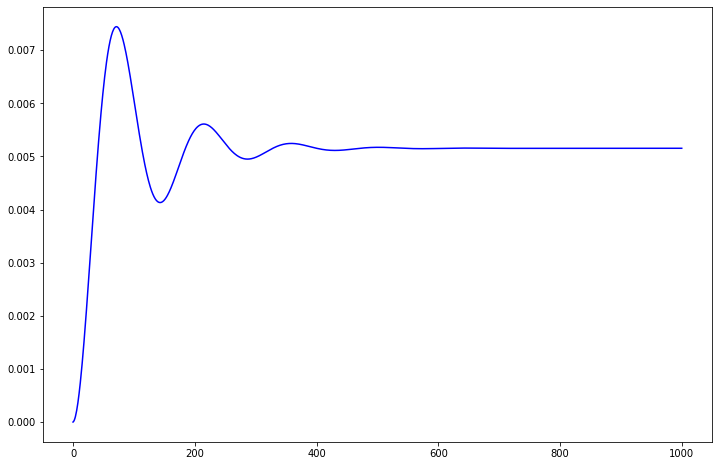

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(z1, label='back_verif', color=(0, 0, 1))
# plt.savefig('back_verif.png')
plt.show()

In [27]:
data = {
    '精度1e3': z1, 
    '精度1e4': z2,
    '精度1e5': z3,    
}

In [18]:
z2 = main_3d_back()

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 0.546
200 step: 0.985
300 step: 1.424
400 step: 1.857
500 step: 2.290
600 step: 2.728
700 step: 3.166
800 step: 3.608
900 step: 4.047
1000 step: 4.490
1100 step: 4.936
1200 step: 5.381
1300 step: 5.828
1400 step: 6.278
1500 step: 6.725
1600 step: 7.175
1700 step: 7.634
1800 step: 8.083
1900 step: 8.634
2000 step: 9.171
2100 step: 9.646
2200 step: 10.136
2300 step: 10.620
2400 step: 11.126
2500 step: 11.649
2600 step: 12.204
2700 step: 12.693
2800 step: 13.176
2900 step: 13.676
3000 step: 14.165
3100 step: 14.645
3200 step: 15.119
3300 step: 15.641
3400 step: 16.145
3500 step: 16.631
3600 step: 17.114
3700 step: 17.613
3800 step: 18.110
3900 step: 18.593
4000 step: 19.077
4100 step: 19.581
4200 step: 20.073
4300 step: 20.560
4400 step: 21.060
4500 step: 21.576
4600 step: 22.123
4700 step: 22.655
4800 step: 23.160
4900 step: 23.683
5000 step: 24.177
5100 step: 24.676
5200 step: 25.179
5300 step: 25.685
5400 step: 26.188
5500 step: 26.699
5600 step: 27.213
5700 step: 27.713
5800

In [20]:
check2 = np.zeros(len(z1), dtype=np.float64)
for i in range(1, len(check2)):
    check2[i] = z2[i * 10]

In [21]:
z2 = check2

In [22]:
z2

array([0.00000000e+00, 6.32368458e-06, 2.34707842e-05, ...,
       5.15226947e-03, 5.15227057e-03, 5.15227196e-03])

In [24]:
check3 = main_3d_back()

/Users/liyuanzhong/.local/share/virtualenvs/jupyter_notebook-7K2ALvDy/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 step: 1.123
200 step: 1.567
300 step: 1.994
400 step: 2.423
500 step: 2.855
600 step: 3.290
700 step: 3.727
800 step: 4.157
900 step: 4.593
1000 step: 5.025
1100 step: 5.464
1200 step: 5.906
1300 step: 6.350
1400 step: 6.800
1500 step: 7.253
1600 step: 7.724
1700 step: 8.237
1800 step: 8.734
1900 step: 9.207
2000 step: 9.697
2100 step: 10.172
2200 step: 10.686
2300 step: 11.155
2400 step: 11.639
2500 step: 12.128
2600 step: 12.620
2700 step: 13.087
2800 step: 13.566
2900 step: 14.060
3000 step: 14.550
3100 step: 15.034
3200 step: 15.539
3300 step: 16.072
3400 step: 16.600
3500 step: 17.122
3600 step: 17.634
3700 step: 18.118
3800 step: 18.608
3900 step: 19.143
4000 step: 19.649
4100 step: 20.145
4200 step: 20.630
4300 step: 21.125
4400 step: 21.617
4500 step: 22.119
4600 step: 22.615
4700 step: 23.107
4800 step: 23.595
4900 step: 24.082
5000 step: 24.576
5100 step: 25.084
5200 step: 25.596
5300 step: 26.089
5400 step: 26.581
5500 step: 27.096
5600 step: 27.601
5700 step: 28.095
580

42700 step: 224.126
42800 step: 224.661
42900 step: 225.184
43000 step: 225.705
43100 step: 226.205
43200 step: 226.732
43300 step: 227.272
43400 step: 227.817
43500 step: 228.353
43600 step: 228.878
43700 step: 229.423
43800 step: 229.964
43900 step: 230.503
44000 step: 231.053
44100 step: 231.589
44200 step: 232.122
44300 step: 232.652
44400 step: 233.190
44500 step: 233.727
44600 step: 234.258
44700 step: 234.800
44800 step: 235.339
44900 step: 235.879
45000 step: 236.414
45100 step: 236.948
45200 step: 237.492
45300 step: 238.023
45400 step: 238.554
45500 step: 239.101
45600 step: 239.641
45700 step: 240.177
45800 step: 240.712
45900 step: 241.247
46000 step: 241.779
46100 step: 242.307
46200 step: 242.849
46300 step: 243.391
46400 step: 243.926
46500 step: 244.462
46600 step: 245.001
46700 step: 245.539
46800 step: 246.067
46900 step: 246.599
47000 step: 247.148
47100 step: 247.691
47200 step: 248.228
47300 step: 248.764
47400 step: 249.301
47500 step: 249.835
47600 step: 250.364


83700 step: 459.901
83800 step: 460.367
83900 step: 460.839
84000 step: 461.349
84100 step: 461.849
84200 step: 462.349
84300 step: 462.844
84400 step: 463.330
84500 step: 463.821
84600 step: 464.315
84700 step: 464.810
84800 step: 465.309
84900 step: 466.229
85000 step: 467.122
85100 step: 468.006
85200 step: 468.894
85300 step: 469.803
85400 step: 470.736
85500 step: 471.685
85600 step: 472.595
85700 step: 473.502
85800 step: 474.405
85900 step: 475.305
86000 step: 476.187
86100 step: 477.077
86200 step: 477.965
86300 step: 478.865
86400 step: 479.769
86500 step: 480.659
86600 step: 481.554
86700 step: 482.357
86800 step: 482.804
86900 step: 483.257
87000 step: 483.723
87100 step: 484.182
87200 step: 484.678
87300 step: 485.185
87400 step: 485.665
87500 step: 486.147
87600 step: 486.639
87700 step: 487.114
87800 step: 487.596
87900 step: 488.080
88000 step: 488.784
88100 step: 489.673
88200 step: 490.550
88300 step: 491.435
88400 step: 492.319
88500 step: 493.237
88600 step: 494.166


In [25]:
z3 = np.zeros(len(z1), dtype=np.float64)
for i in range(1, len(z3)):
    z3[i] = check3[i * 100]

In [26]:
z3

array([0.00000000e+00, 5.83682774e-06, 2.25347597e-05, ...,
       5.15225512e-03, 5.15225662e-03, 5.15225843e-03])

In [28]:
import pickle

In [29]:
with open('back_data', 'wb') as f:
    pickle.dump(data, f)

In [31]:
with open('back_data', 'rb') as rf:
    data = pickle.load(rf)

In [32]:
data

{'精度1e3': array([0.00000000e+00, 1.10756279e-05, 3.26203929e-05, ...,
        5.15236784e-03, 5.15236700e-03, 5.15236632e-03]),
 '精度1e4': array([0.00000000e+00, 6.32368458e-06, 2.34707842e-05, ...,
        5.15226947e-03, 5.15227057e-03, 5.15227196e-03]),
 '精度1e5': array([0.00000000e+00, 5.83682774e-06, 2.25347597e-05, ...,
        5.15225512e-03, 5.15225662e-03, 5.15225843e-03])}

In [33]:
diff1 = 0.0
max_diff1 = 0.0
for (i, j) in zip(z1, z3):
    diff1 += abs(i - j)
    max_diff1 = max(max_diff1, abs(i - j))

average_diff1 = diff1 / len(z1)    
print('average_diff: {0}, max_diff: {1}'.format(average_diff1, max_diff1))


average_diff: 2.893428055869683e-05, max_diff: 0.00017324815615600824


In [34]:
diff2 = 0.0
max_diff2 = 0.0
for (i, j) in zip(z2, z3):
    diff2 += abs(i - j)
    max_diff2 = max(max_diff2, abs(i - j))

average_diff2 = diff2 / len(z2)    
print('average_diff: {0}, max_diff: {1}'.format(average_diff2, max_diff2))

average_diff: 2.8577726483374802e-06, max_diff: 1.6318332164395356e-05


In [35]:
diff_data = {
    '精度1e3': {
        'dis': z1,
        'total_diff': diff1,
        'average_diff': average_diff1,
        'max_diff': max_diff1
    },
    '精度1e4': {
        'dis': z2,
        'total_diff': diff2,
        'average_diff': average_diff2,
        'max_diff': max_diff2
    }
}

In [36]:
x = np.array([1e3, 1e4])
y1 = np.array([average_diff1, average_diff2])
y2 = np.array([max_diff1, max_diff2])

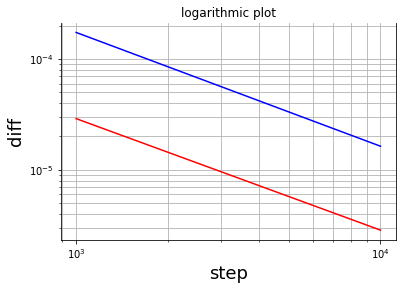

In [37]:
plt.plot(x, y1, color='red', label='average_diff')
plt.plot(x, y2, color='blue', label='max_diff')

ax = plt.gca()
ax.spines['top'].set_color('none')

##
ax.set_yscale('log')  # メイン: y軸をlogスケールで描く
ax.set_xscale('log')
##
plt.title('logarithmic plot') 
plt.xlabel('step',fontsize=18)
plt.ylabel('diff',fontsize=18)

plt.grid(which="both") # グリッド表示。"both"はxy軸両方にグリッドを描く。
plt.savefig('diff_back1.png')

plt.show()

In [39]:
with open('back_diff_data1', 'wb') as f:
    pickle.dump(diff_data, f)